In [4]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

True

We want to explain our portfolio, or single stock, using factors defined by the a series of linear models that relates the expected return of a stock to several historical factors of the market. The most simple of these is the CAPM model, which aims to relate the expected return of an asset to the the expected return of the market. The model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f)
$$

Where:
- $E[R_i]$ is the expected return of the stock
- $R_f$ is the risk-free rate
- $\beta_i$ is the beta of the stock
- $E[R_m]$ is the expected return of the market

The beta of a stock is a measure of the stock's volatility in relation to the market. A beta of 1 means that the stock moves in line with the market. A beta greater than 1 means that the stock is more volatile than the market, and a beta less than 1 means that the stock is less volatile than the market.

In our case, we will grab the market excess returns from the Kenneth French data library.

This same model is used extended by the Fama-French 3 factor model, which adds two more factors to the model. The Fama-French model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f) + s_i SMB + h_i HML
$$

Where:
- $s_i$ is the stock's exposure to the size factor
- $SMB$ is the size factor
- $h_i$ is the stock's exposure to the value factor
- $HML$ is the value factor

This model can be extended further to the Fama-French 5 factor model, which adds two more factors to the model. The Fama-French 5 factor model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f) + s_i SMB + h_i HML + r_i RMW + c_i CMA
$$

Where:
- $r_i$ is the stock's exposure to the profitability factor
- $RMW$ is the profitability factor
- $c_i$ is the stock's exposure to the investment factor
- $CMA$ is the investment factor

[*********************100%%**********************]  1 of 1 completed


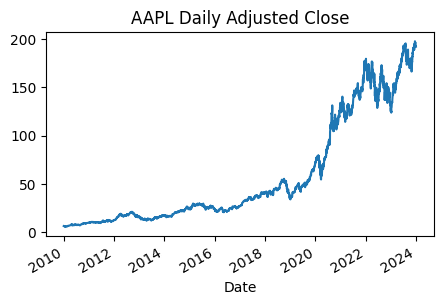

In [34]:
# As an example, we will use the stock of Apple Inc. (AAPL)
returns = yf.download("AAPL", start="2010-01-01", end="2023-12-31")
returns["Adj Close"].plot(title="AAPL Daily Adjusted Close", figsize=(5, 3))
plt.show()

In [6]:
# calculate daily returns of QQQ
# data = returns["Adj Close"].to_frame()
# data["Return"] = data["Adj Close"].pct_change() * 100
# data.dropna(inplace=True)
# data

data = returns["Adj Close"].resample("ME").ffill().to_frame()
data.index = data.index.to_period("M")
data["Return"] = data["Adj Close"].pct_change() * 100
data.dropna(inplace=True)
data

,Adj Close,Return
Date,,
2010-02,6.178449,6.539645
2010-03,7.095762,14.846989
2010-04,7.883543,11.102123
2010-05,7.756423,-1.612467
2010-06,7.594882,-2.082668
...,...,...
2023-08,187.129898,-4.238376
2023-09,170.535538,-8.867830
2023-10,170.097260,-0.257001


In [40]:
def get_monthly_returns(tickers, start_date, end_date):
    all_data = {}
    for ticker in tickers:
        returns = yf.download(ticker, start=start_date, end=end_date)
        data = returns["Adj Close"].resample("ME").ffill().to_frame()
        data.index = data.index.to_period("M")
        data["Return"] = data["Adj Close"].pct_change() * 100
        data.dropna(inplace=True)
        all_data[ticker] = data["Return"]
    return pd.DataFrame(all_data)

# We will also take the data of a portfolio with weights
weights = [0.25, 0.25, 0.25, 0.25] # currently, weights are hardcoded, but need to change to 
portfolio = get_monthly_returns(["AAPL", "AMZN", "GOOGL", "MSFT"], "2010-01-01", "2023-12-31")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [27]:
# get CAPM model factors
# factors = pd.read_csv("data/ff3_daily_data.csv", index_col=0)
# factors.index.name = "Date"
# factors.index = pd.to_datetime(factors.index, format="%Y%m%d")
# factors.index = factors.index.to_period("D")
# factors

factors_monthly = pd.read_csv("data/ff5_monthly_data.csv", index_col=0)
factors_monthly.index.name = "Date"
factors_monthly.index = pd.to_datetime(factors_monthly.index, format="%Y%m")
factors_monthly.index = factors_monthly.index.to_period("M")
factors_monthly

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2023-12,4.87,7.32,4.93,-3.07,1.32,0.43
2024-01,0.70,-5.74,-2.38,0.69,-0.96,0.47
2024-02,5.06,-0.78,-3.49,-1.99,-2.14,0.42


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

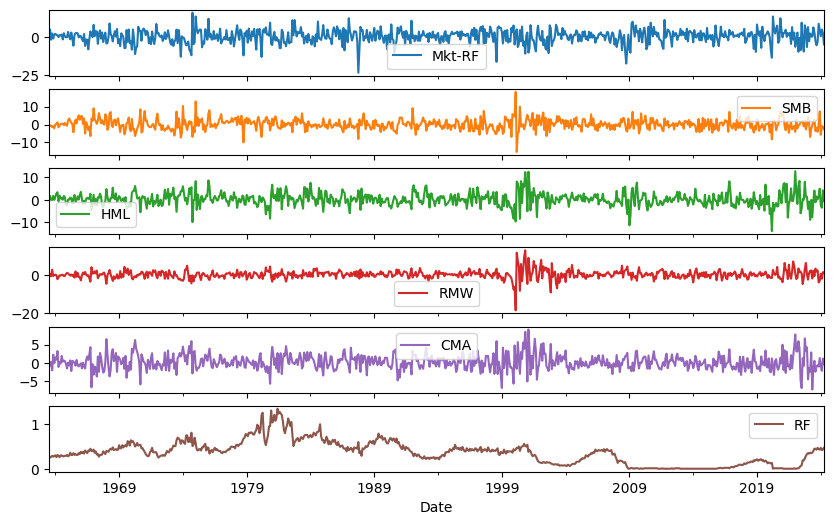

In [28]:
# plot factors across time
factors_monthly.plot(subplots=True, figsize=(10, 6))

<Axes: title={'center': 'Portfolio Monthly Returns'}, xlabel='Date'>

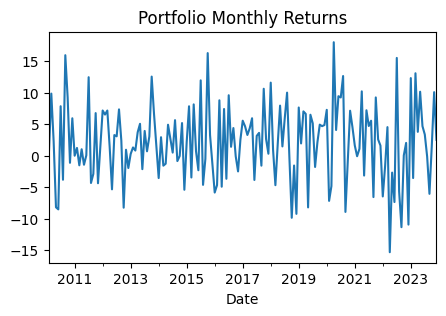

In [43]:
portfolio_return = (portfolio * weights).sum(axis=1)
# plot portfolio returns
portfolio_return.plot(title="Portfolio Monthly Returns", figsize=(5, 3))

In [44]:
factors_subset = factors_monthly[factors_monthly.index.isin(data.index)].copy()
factors_subset["Excess Returns"] = portfolio_return - factors_subset["RF"]
# factors_subset["Excess Returns"] = data["Return"] - factors_subset["RF"]
factors_subset

,Mkt-RF,SMB,HML,RMW,CMA,RF,Excess Returns
Date,,,,,,,
2010-02,3.40,1.51,3.23,-0.27,1.43,0.00,0.643001
2010-03,6.31,1.85,2.21,-0.65,1.69,0.01,9.823478
2010-04,2.00,4.98,2.89,0.69,1.72,0.01,2.251450
2010-05,-7.89,0.04,-2.44,1.30,-0.21,0.01,-8.226065
2010-06,-5.57,-2.47,-4.70,-0.16,-1.55,0.01,-8.556469
...,...,...,...,...,...,...,...
2023-08,-2.39,-3.65,-1.06,3.43,-2.37,0.45,-0.605602
2023-09,-5.24,-1.80,1.52,1.86,-0.83,0.43,-6.510590
2023-10,-3.19,-4.05,0.18,2.47,-0.65,0.47,1.114947


In [45]:
# X = sm.add_constant(factors_subset[["Mkt-RF"]]) # CAPM model
# X = sm.add_constant(factors_subset[["Mkt-RF", "SMB", "HML"]]) # Fama-French 3-factor model
X = sm.add_constant(factors_subset[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]) # Fama-French 5-factor model
y = factors_subset["Excess Returns"]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Excess Returns   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     102.8
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           2.88e-48
Time:                        15:48:37   Log-Likelihood:                -415.53
No. Observations:                 167   AIC:                             843.1
Df Residuals:                     161   BIC:                             861.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7786      0.242      3.224      0.002       0.302       1.256
Mkt-RF         1.1391      0.057     20.028      0.000       1.027       1.251
SMB           -0.5024      0.109     -4.607      0.000      -0.718      -0.287
HML           -0.2268      0.099     -2.302      0.023      -0.421      -0.032
RMW            0.0450      0.131      0.344      0.732      -0.213       0.303
CMA           -0.5745      0.148     -3.886      0.000      -0.866      -0.283
==============================================================================
Omnibus:                       15.983   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.638
Skew:                           0.583   Prob(JB):                     2.00e-05
Kurtosis:                       4.322   Cond. No.                         5.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

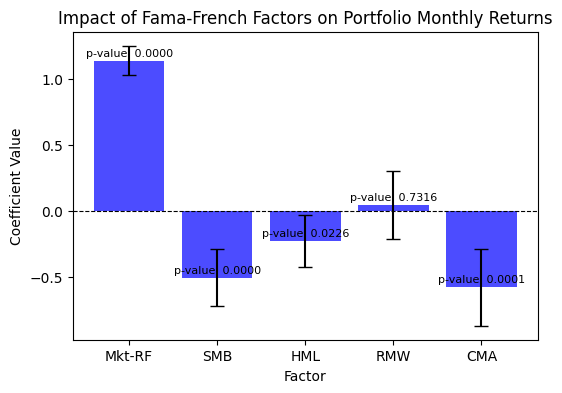

In [32]:
# Assuming `model` is your OLS regression model
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().iloc[1:]

# Create a DataFrame
ols_data = pd.DataFrame({
    "Factor": factors,
    "Coefficient": coefficients,
    "Confidence_Lower": confidence_intervals[0],
    "Confidence_Upper": confidence_intervals[1],
    "P-Value": model.pvalues[1:]
})

# Plotting for visual confirmation
plt.figure(figsize=(6, 4))

bars = plt.bar(ols_data["Factor"], ols_data["Coefficient"], color='blue', alpha=0.7, capsize=10)
plt.errorbar(
    ols_data["Factor"],
    ols_data["Coefficient"],
    yerr=[
        ols_data["Coefficient"] - ols_data["Confidence_Lower"],
        ols_data["Confidence_Upper"] - ols_data["Coefficient"]
    ],
    fmt='none',
    capsize=5,
    color='black'
)

# Add the p-value for each factor to the plot
for i, row in ols_data.iterrows():
    plt.text(
        i,
        row['Coefficient'] + 0.02,  # Position text slightly above the bar
        f"p-value: {row['P-Value']:.4f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.title("Impact of Fama-French Factors on Portfolio Monthly Returns")
plt.xlabel("Factor")
plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.show()

In [ ]:
client = OpenAI()

def get_insights(dataframe, portfolio, advanced=False):
    data_string = dataframe.to_string()
    portfolio_string = portfolio.to_string()
    
    prompt = f"""
        Analyze the following regression results data and provide insights:

        {data_string}

        Additionally, here is the portfolio composition:

        {portfolio_string}

        Determine which factor correlations affect which tickers in the portfolio the most based on the regression coefficients and provide a detailed analysis.
    """
    if advanced:
        messages = [
            {"role": "system", "content": "You are a financial analyst who provides insights on regression analysis for either a single stock or a portfolio of stocks. You are expected to provide more detailed and technical insights."},
            {"role": "user", "content": f"Analyze the following regression results data and provide insights:\n\n{data_string}\n\n"}
        ]
    else:
        messages = [
            {"role": "system", "content": "You are a financial analyst who provides insights on regression analysis for either a single stock or a portfolio of stock. You are speaking to a general audience and should provide high-level insights without getting too technical."},
            {"role": "user", "content": f"Analyze the following regression results data and provide insights. Do not get too technical, and there is no need to explain exactly what each factor is. Rather, give high-level insights on the regression and what it means about the stock/portfolio.:\n\n{data_string}\n\n"}
        ]
    
    completion = client.chat.completions.create(model='gpt-4o-mini', messages=messages)
    
    return completion.choices[0].message.content.strip()

# Analyze the OLS regression results using GPT-4
insights = get_insights(ols_data, advanced=False)
print("Insights from GPT-4o:\n", insights)

In [46]:
# Future forecasting from different models by looking at previous factor trends and forcasting the next 12 months
from statsmodels.tsa.arima.model import ARIMA

def forecast_factors(factors, model_type, steps=12):
    forecasted_factors = {}
    
    if model_type == "capm":
        factor_headers = ["Mkt-RF"]
    elif model_type == "ff3":
        factor_headers = ["Mkt-RF", "SMB", "HML"]
    elif model_type == "ff5":
        factor_headers = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]
    else:
        raise ValueError("Invalid model type. Choose from 'capm', 'ff3', or 'ff5'.")
        
    for factor in factor_headers:
        model = ARIMA(factors[factor], order=(1, 1, 1))
        fit_model = model.fit()
        forecast = fit_model.forecast(steps=steps)
        forecasted_factors[factor] = forecast
    return forecasted_factors

def compute_monthly_expected_returns(model, forecasted_factors):
    monthly_expected_returns = []
    for i in range(12):
        monthly_return = model.params['const']
        for factor in forecasted_factors:
            monthly_return += model.params[factor] * forecasted_factors[factor].iloc[i]
        monthly_expected_returns.append(monthly_return)
    return monthly_expected_returns

def compute_annual_return(monthly_expected_returns):
    cumulative_return = 1
    for monthly_return in monthly_expected_returns:
        cumulative_return *= (1 + monthly_return / 100)
    annual_return = cumulative_return - 1
    return annual_return

forecasted_factors = forecast_factors(factors_monthly, model_type="ff5", steps=12)
monthly_expected_returns = compute_monthly_expected_returns(model, forecasted_factors)
annual_expected_return = compute_annual_return(monthly_expected_returns)

print(monthly_expected_returns)
print("Expected Annual Return for the Next 12 Months: {:.2f}%".format(annual_expected_return * 100))

[1.1349458066864058, 1.2388070512651905, 1.2346642314899985, 1.2333270543373462, 1.2331036794897619, 1.2330694376358768, 1.233064223759194, 1.233063423188363, 1.2330632990642003, 1.233063279654901, 1.2330632765978458, 1.2330632761133427]
Expected Annual Return for the Next 12 Months: 15.74%


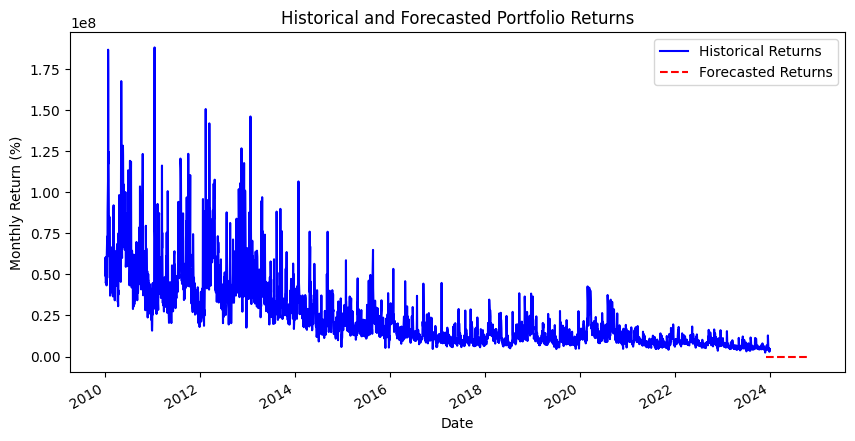

In [24]:
def visualize_returns(historical_returns, forecasted_returns):
    plt.figure(figsize=(10, 5))
    
    # Plot historical returns
    historical_returns.plot(label='Historical Returns', color='blue')
    
    # Create a DataFrame for forecasted returns
    forecast_index = pd.period_range(start=historical_returns.index[-1], periods=12, freq='M')
    forecasted_returns_df = pd.Series(forecasted_returns, index=forecast_index, name='Forecasted Returns')
    
    # Plot forecasted returns
    forecasted_returns_df.plot(label='Forecasted Returns', color='red', linestyle='--')
    
    plt.title('Historical and Forecasted Portfolio Returns')
    plt.xlabel('Date')
    plt.ylabel('Monthly Return (%)')
    plt.legend()
    plt.show()

weights = [0.25, 0.15, 0.2, 0.1, 0.2, 0.1] 
portfolio_return = (returns * weights).sum(axis=1)
visualize_returns(portfolio_return, monthly_expected_returns)

In [ ]:
# To test: given the regression results and the portolio allocation, use an LLM to analyze future performances  